In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-01-20 14:33:51.487743: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# import random

# random.seed(10)
# print(random.random())

In [4]:
data = pd.read_csv("../../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


In [5]:
data

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,231.97,0,0,0,1,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,237.78,0,0,0,1,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,242.70,0,0,0,1,0,0


In [6]:
data.columns

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain', 'NE',
       'NW', 'SE', 'cv'],
      dtype='object')

(array([1.7727e+04, 1.0511e+04, 6.4690e+03, 3.7450e+03, 2.2240e+03,
        1.3270e+03, 7.5900e+02, 4.6700e+02, 2.8700e+02, 1.5400e+02,
        7.2000e+01, 2.5000e+01, 7.0000e+00, 8.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([  0. ,  49.7,  99.4, 149.1, 198.8, 248.5, 298.2, 347.9, 397.6,
        447.3, 497. , 546.7, 596.4, 646.1, 695.8, 745.5, 795.2, 844.9,
        894.6, 944.3, 994. ]),
 <BarContainer object of 20 artists>)

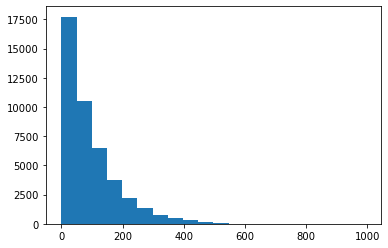

In [7]:
plt.hist(data['pollution'], bins=20)

In [8]:
np.percentile(data['pollution'], 95)

281.0

### Preprocess

In [8]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (43717, 924)


In [9]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 792) (30601, 12) (6558, 792) (6558, 12) (6558, 792) (6558, 12)


In [10]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 72, 11) (30601, 12) (6558, 72, 11) (6558, 12) (6558, 72, 11) (6558, 12)


### Model & training

In [15]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [16]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [17]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate, 
#                                                           decay_steps=decay_steps,
#                                                           decay_rate=decay_rate)

# model.compile(optimizer=Adam(learning_rate=lr_schedule),
#               loss='mse',
#               metrics=['mae']
#              )

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/pm_all.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc]
         )

Epoch 1/1000
60/60 - 2s - loss: 0.0070 - mae: 0.0606 - val_loss: 0.0117 - val_mae: 0.0754

Epoch 00001: val_mae improved from inf to 0.07539, saving model to ../../saved_models/pm_all.h5
Epoch 2/1000
60/60 - 1s - loss: 0.0044 - mae: 0.0456 - val_loss: 0.0100 - val_mae: 0.0672

Epoch 00002: val_mae improved from 0.07539 to 0.06723, saving model to ../../saved_models/pm_all.h5
Epoch 3/1000
60/60 - 1s - loss: 0.0040 - mae: 0.0429 - val_loss: 0.0092 - val_mae: 0.0640

Epoch 00003: val_mae improved from 0.06723 to 0.06399, saving model to ../../saved_models/pm_all.h5
Epoch 4/1000
60/60 - 1s - loss: 0.0038 - mae: 0.0413 - val_loss: 0.0086 - val_mae: 0.0616

Epoch 00004: val_mae improved from 0.06399 to 0.06157, saving model to ../../saved_models/pm_all.h5
Epoch 5/1000
60/60 - 1s - loss: 0.0036 - mae: 0.0403 - val_loss: 0.0085 - val_mae: 0.0610

Epoch 00005: val_mae improved from 0.06157 to 0.06104, saving model to ../../saved_models/pm_all.h5
Epoch 6/1000
60/60 - 1s - loss: 0.0036 - mae: 0.0


Epoch 00056: val_mae did not improve from 0.05989
Epoch 57/1000
60/60 - 1s - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0128 - val_mae: 0.0785

Epoch 00057: val_mae did not improve from 0.05989
Epoch 58/1000
60/60 - 1s - loss: 0.0017 - mae: 0.0289 - val_loss: 0.0135 - val_mae: 0.0801

Epoch 00058: val_mae did not improve from 0.05989
Epoch 59/1000
60/60 - 1s - loss: 0.0016 - mae: 0.0283 - val_loss: 0.0138 - val_mae: 0.0816

Epoch 00059: val_mae did not improve from 0.05989
Epoch 60/1000
60/60 - 1s - loss: 0.0016 - mae: 0.0286 - val_loss: 0.0130 - val_mae: 0.0795

Epoch 00060: val_mae did not improve from 0.05989
Epoch 61/1000
60/60 - 1s - loss: 0.0016 - mae: 0.0281 - val_loss: 0.0133 - val_mae: 0.0801

Epoch 00061: val_mae did not improve from 0.05989
Epoch 62/1000
60/60 - 1s - loss: 0.0016 - mae: 0.0277 - val_loss: 0.0133 - val_mae: 0.0809

Epoch 00062: val_mae did not improve from 0.05989
Epoch 63/1000
60/60 - 1s - loss: 0.0015 - mae: 0.0274 - val_loss: 0.0138 - val_mae: 0.0824

Epoch

60/60 - 1s - loss: 9.2506e-04 - mae: 0.0215 - val_loss: 0.0177 - val_mae: 0.0946

Epoch 00114: val_mae did not improve from 0.05989
Epoch 115/1000
60/60 - 1s - loss: 9.1727e-04 - mae: 0.0214 - val_loss: 0.0179 - val_mae: 0.0953

Epoch 00115: val_mae did not improve from 0.05989
Epoch 116/1000
60/60 - 1s - loss: 9.0872e-04 - mae: 0.0213 - val_loss: 0.0179 - val_mae: 0.0958

Epoch 00116: val_mae did not improve from 0.05989
Epoch 117/1000
60/60 - 1s - loss: 8.9935e-04 - mae: 0.0212 - val_loss: 0.0179 - val_mae: 0.0952

Epoch 00117: val_mae did not improve from 0.05989
Epoch 118/1000
60/60 - 1s - loss: 8.9009e-04 - mae: 0.0211 - val_loss: 0.0178 - val_mae: 0.0952

Epoch 00118: val_mae did not improve from 0.05989
Epoch 119/1000
60/60 - 1s - loss: 8.9119e-04 - mae: 0.0212 - val_loss: 0.0185 - val_mae: 0.0967

Epoch 00119: val_mae did not improve from 0.05989
Epoch 120/1000
60/60 - 1s - loss: 8.6060e-04 - mae: 0.0207 - val_loss: 0.0178 - val_mae: 0.0952

Epoch 00120: val_mae did not improve

60/60 - 1s - loss: 6.7502e-04 - mae: 0.0184 - val_loss: 0.0208 - val_mae: 0.1037

Epoch 00170: val_mae did not improve from 0.05989
Epoch 171/1000
60/60 - 1s - loss: 6.6815e-04 - mae: 0.0182 - val_loss: 0.0207 - val_mae: 0.1034

Epoch 00171: val_mae did not improve from 0.05989
Epoch 172/1000
60/60 - 1s - loss: 6.3335e-04 - mae: 0.0177 - val_loss: 0.0208 - val_mae: 0.1034

Epoch 00172: val_mae did not improve from 0.05989
Epoch 173/1000
60/60 - 1s - loss: 6.4359e-04 - mae: 0.0178 - val_loss: 0.0214 - val_mae: 0.1049

Epoch 00173: val_mae did not improve from 0.05989
Epoch 174/1000
60/60 - 1s - loss: 6.3925e-04 - mae: 0.0178 - val_loss: 0.0210 - val_mae: 0.1042

Epoch 00174: val_mae did not improve from 0.05989
Epoch 175/1000
60/60 - 1s - loss: 6.5061e-04 - mae: 0.0180 - val_loss: 0.0217 - val_mae: 0.1059

Epoch 00175: val_mae did not improve from 0.05989
Epoch 176/1000
60/60 - 1s - loss: 6.3465e-04 - mae: 0.0177 - val_loss: 0.0212 - val_mae: 0.1047

Epoch 00176: val_mae did not improve